In [1]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:

from keras.models import load_model
model = load_model('/Users/hardika/Downloads/PROJECT/deep-learning-models-master/saved_models/Emotion_Detection_Model.h5')

/Users/hardika/anaconda3/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:

from keras.models import load_model
model = load_model('/Users/hardika/Downloads/PROJECT/Transfer-Learning-in-keras---custom-data-master/SENET_WEIGHTS.h5')

In [19]:
img_path = '/Users/hardika/Downloads/PROJECT/Transfer-Learning-in-keras---custom-data-master/photo.tif'

In [20]:
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [21]:
print(img_tensor.shape)

(1, 224, 224, 3)


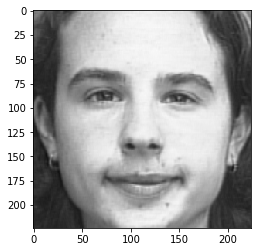

In [22]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [23]:

from keras import activations
from keras import models
#layer_outputs = [layer.output for layer in model.layers[:19]]
layer_outputs = [layer.output for layer in model.layers[1:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [24]:
activations = activation_model.predict(img_tensor)

In [25]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 230, 230, 3)


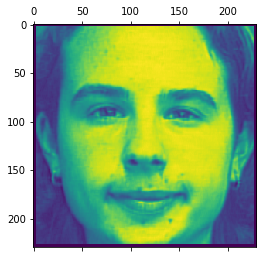

In [26]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

/Users/hardika/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))
/Users/hardika/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/hardika/anaconda3/lib/python3.5/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/hardika/anaconda3/lib/python3.5/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

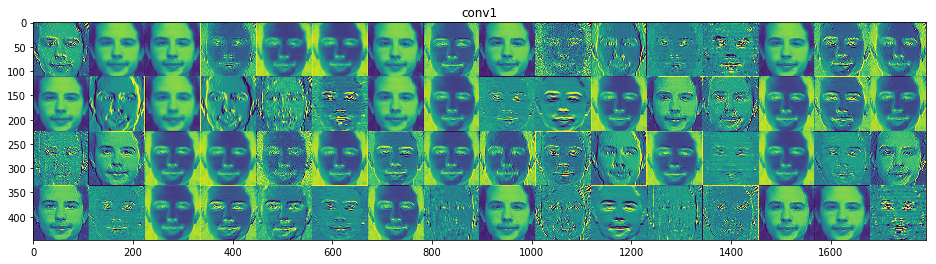

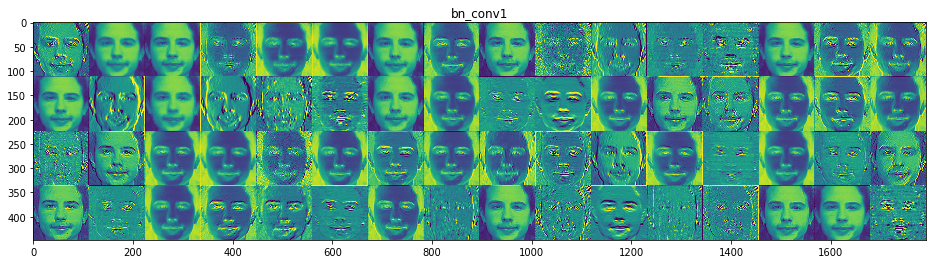

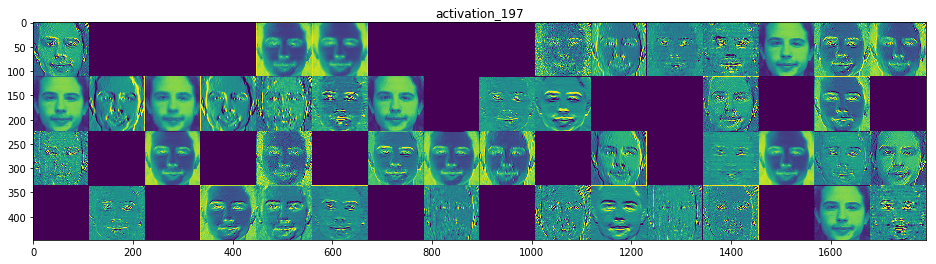

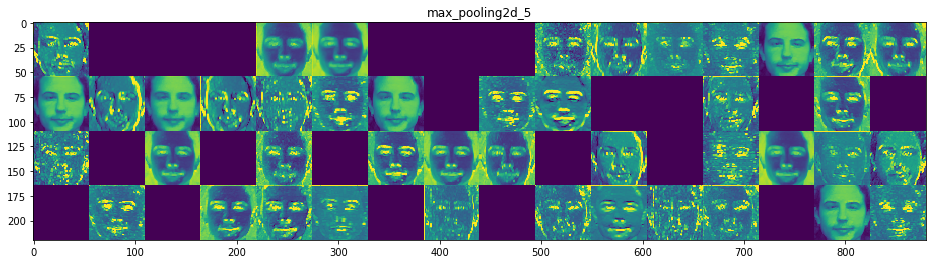

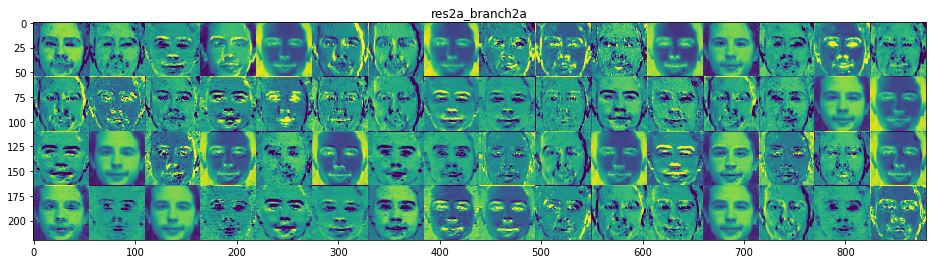

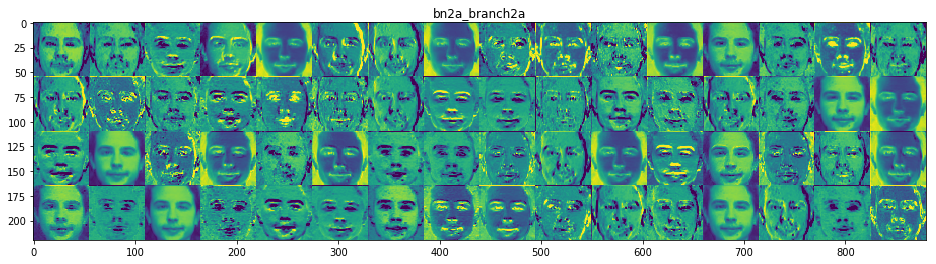

In [27]:
layer_names = []
for layer in model.layers[1:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [11]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

NameError: name 'preprocess_input' is not defined

In [38]:
preds = model.predict(x)
argmax = np.argmax(preds[0])

In [39]:

output = model.output[:,argmax]
print(output.shape)
output

(?,)


<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [40]:
last_conv_layer = model.get_layer('block5_conv3')
last_conv_layer

In [41]:
from keras import backend as K
grads = K.gradients(output, last_conv_layer.output)[0]
grads

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0xb35daac88>>
Traceback (most recent call last):
  File "/Users/hardika/anaconda3/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1467, in __del__
    self._session._session, self._handle, status)
  File "/Users/hardika/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140302783069568


<tf.Tensor 'gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>

In [42]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [43]:
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

In [44]:
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

In [45]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

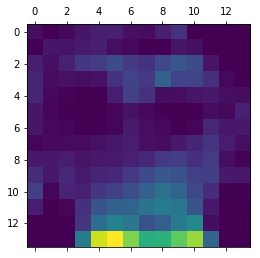

In [46]:
import matplotlib.pyplot as plt
plt.matshow(heatmap)

In [47]:

import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

In [48]:
CAM_output = cv2.imwrite('/Users/hardika/Desktop/project/CAM_output1.png', superimposed_img)
out_img_path = '/Users/hardika/Desktop/project/CAM_output1.png'
out_img = image.load_img(out_img_path, target_size=(224, 224))
out_img_tensor = image.img_to_array(out_img)
out_img_tensor = np.expand_dims(out_img_tensor, axis=0)
out_img_tensor /= 255.

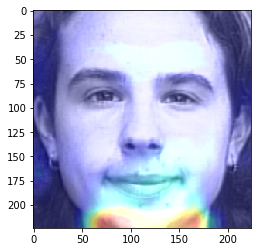

In [49]:
import matplotlib.pyplot as plt
plt.imshow(out_img_tensor[0])
plt.show()